
## Машинное обучение 2
### Семинар 13. Обучение с подкреплением

<br />
<br />
12 мая 2022

[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1igPnv-YJprmpiw8HaJZK_QVJ-L85o4uK?usp=sharing)

Источники вдохновения: 

https://github.com/andriygav/MachineLearningSeminars/blob/master/sem25/

https://github.com/mswang12/minDQN

Видео семинара МФТИ https://www.youtube.com/watch?v=3Xex0Z5D6O8

## Библиотеки

In [1]:
from abc import abstractmethod

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

## Задача о заплыве

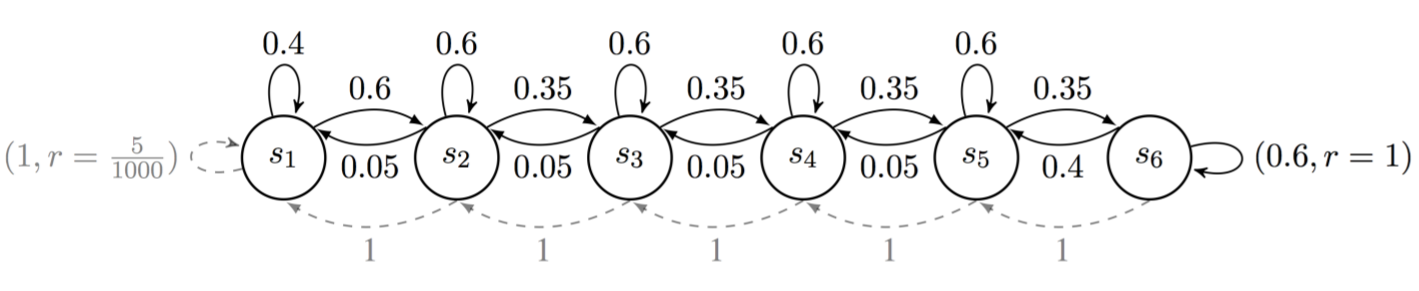

https://arxiv.org/pdf/1306.0940.pdf

Задача на основе марковских процесов. Всего два действия — пытаться плыть против течения или не пытаться.


In [2]:
class RiverSwim:
    def __init__(self, 
                 isc  = 4, # число состояний (без учета крайних)
                 ms   = 16, # максимальное число шагов, которое делаем за один эпизод
                 lr   = 5/1000, 
                 rr   = 1.0, 
                 seed = 42):
        self.rs = np.random.RandomState(seed)
        self._max_steps = ms
        self._interm_states = isc

        self._steps = 0
        self._current_state = 1

        self.lr = lr
        self.rr = rr
        
    @property
    def action_count(self):
        return 2
    
    @property
    def states_count(self):
        return 2 + self._interm_states
    
    def _get_probs(self, action):
        if action == 0:
            if self._current_state == 0:
                return [0.00, 1.00, 0.00]
            else:
                return [1.00, 0.00, 0.00]
            
        elif action == 1:
            if self._current_state == 0:
                return [0.00, 0.40, 0.60]
            if self._current_state == self.states_count - 1:
                return [0.40, 0.60, 0.00]
            else:
                return [0.05, 0.60, 0.35]

    def step(self, action):
        reward = 0.0
        if self._steps >= self._max_steps:
            return self._current_state, reward, True
        
        transition = self.rs.choice(range(3), p=self._get_probs(action))
        if transition == 0:
            self._current_state -= 1
        elif transition == 1:
            pass
        else:
            self._current_state += 1

        if self._current_state == 0:
            reward = self.lr
        elif self._current_state == self.states_count - 1:
            reward = self.rr
        
        self._steps += 1
        return self._current_state, reward, False

In [3]:
class QLearningAgent:
    def __init__(self, n, K, lr=0.2, gamma=0.95, epsilon=0.2, seed=42):
        self.rs = np.random.RandomState(seed)
        self._gamma = gamma
        self._epsilon = epsilon
        self._q_matrix = np.zeros((n, K))
        self._lr = lr

    def get_action(self, state):
        if self.rs.random() < self._epsilon:
            return self.rs.randint(0, self._q_matrix.shape[1])
        else:
            return np.argmax(self._q_matrix[state])
    
    def get_q_matrix(self):
        return self._q_matrix
        
    def start_episode(self):
        pass

    def update(self, state, action, reward, next_state):
        self._q_matrix[state, action] = self._q_matrix[state, action] + self._lr*(reward + self._gamma*np.max(self._q_matrix[next_state]) - self._q_matrix[state, action])
        return


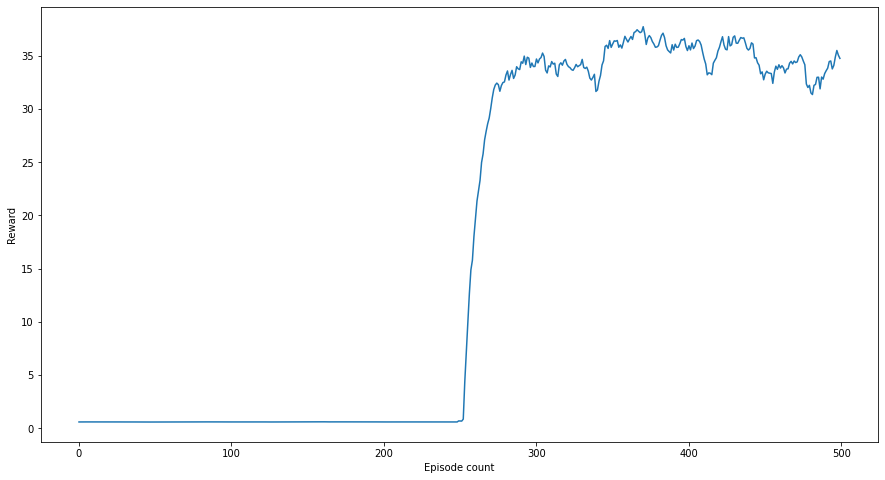

In [4]:
n = 2
ms = 128
episodes = 500
actions = 2

agent = QLearningAgent(2+n, actions)

episode_rewards = []
for ep in range(episodes):
    river_swim = RiverSwim(n, ms)

    state, ep_reward, is_done = river_swim._current_state, 0.0, False
    agent.start_episode()
    while not is_done:
        action = agent.get_action(state)
        next_state, reward, is_done = river_swim.step(action)
        agent.update(state, action, reward, next_state)
        
        state = next_state
        ep_reward += reward
        
    episode_rewards.append(ep_reward)


plt.figure(figsize=(15, 8))

plt.plot(pd.DataFrame(np.array(episode_rewards)).ewm(alpha=.1).mean())
plt.xlabel("Episode count")
plt.ylabel("Reward")
plt.show()

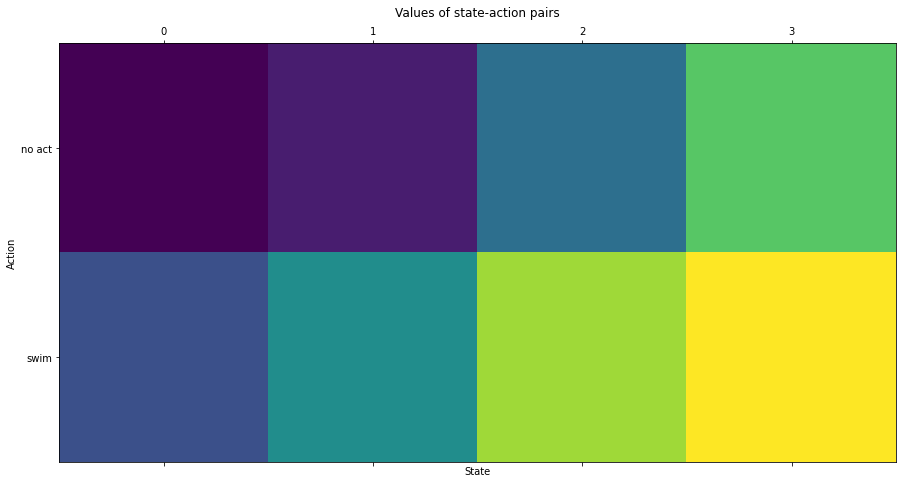

In [5]:
fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(111)
ax.matshow(agent.get_q_matrix().T)
ax.set_yticklabels(['', 'no act', 'swim'])
plt.xlabel("State")
plt.ylabel("Action")
plt.title("Values of state-action pairs")
plt.show()

## A Minimal Deep Q-Network

We'll be showing how to code a minimal Deep Q-Network to solve the CartPole environment.

## Step 1. Import libraries and setup the environment

In [6]:
import gym
import tensorflow as tf
import numpy as np
from tensorflow import keras

from collections import deque
import time
import random

In [7]:
RANDOM_SEED = 5
tf.random.set_seed(RANDOM_SEED)

env = gym.make('CartPole-v1')
env.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

print("Action Space: {}".format(env.action_space))
print("State space: {}".format(env.observation_space))


Action Space: Discrete(2)
State space: Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (4,), float32)


In [8]:
help(env.env)

Help on CartPoleEnv in module gym.envs.classic_control.cartpole object:

class CartPoleEnv(gym.core.Env)
 |  Description:
 |      A pole is attached by an un-actuated joint to a cart, which moves along
 |      a frictionless track. The pendulum starts upright, and the goal is to
 |      prevent it from falling over by increasing and reducing the cart's
 |      velocity.
 |  
 |  Source:
 |      This environment corresponds to the version of the cart-pole problem
 |      described by Barto, Sutton, and Anderson
 |  
 |  Observation:
 |      Type: Box(4)
 |      Num     Observation               Min                     Max
 |      0       Cart Position             -4.8                    4.8
 |      1       Cart Velocity             -Inf                    Inf
 |      2       Pole Angle                -0.418 rad (-24 deg)    0.418 rad (24 deg)
 |      3       Pole Angular Velocity     -Inf                    Inf
 |  
 |  Actions:
 |      Type: Discrete(2)
 |      Num   Action
 |      0  

### Step 2. Define the network architecture

In [9]:
# An episode a full game
train_episodes = 250

def agent(state_shape, action_shape):
    """ The agent maps X-states to Y-actions
    e.g. The neural network output is [.1, .7, .05, 0.05, .05, .05]
    The highest value 0.7 is the Q-Value.
    The index of the highest action (0.7) is action #1.
    """
    learning_rate = 0.001
    init = tf.keras.initializers.HeUniform()
    model = keras.Sequential()
    model.add(keras.layers.Dense(24, input_shape=state_shape, activation='relu', kernel_initializer=init))
    model.add(keras.layers.Dense(12, activation='relu', kernel_initializer=init))
    model.add(keras.layers.Dense(action_shape, activation='linear', kernel_initializer=init))
    model.compile(loss=tf.keras.losses.Huber(), optimizer=tf.keras.optimizers.Adam(lr=learning_rate), metrics=['accuracy'])
    return model

def get_qs(model, state, step):
    return model.predict(state.reshape([1, state.shape[0]]))[0]


### Step 3. Define the train function using Experience Replay


In [10]:
def train(env, replay_memory, model, target_model, done):
    learning_rate = 0.7
    discount_factor = 0.618

    MIN_REPLAY_SIZE = 1000
    if len(replay_memory) < MIN_REPLAY_SIZE:
        return

    batch_size = 64 * 2
    # replay_memory is list of [observation, action, reward, new_observation, done])
    mini_batch = random.sample(replay_memory, batch_size)
    current_states = np.array([transition[0] for transition in mini_batch])
    current_qs_list = model.predict(current_states)
    new_current_states = np.array([transition[3] for transition in mini_batch])
    future_qs_list = target_model.predict(new_current_states)

    X = []
    Y = []
    for index, (observation, action, reward, new_observation, done) in enumerate(mini_batch):
        if not done:
            max_future_q = reward + discount_factor * np.max(future_qs_list[index])
        else:
            max_future_q = reward

        current_qs = current_qs_list[index]
        current_qs[action] = (1 - learning_rate) * current_qs[action] + learning_rate * max_future_q

        X.append(observation)
        Y.append(current_qs)
    model.fit(np.array(X), np.array(Y), batch_size=batch_size, verbose=0, shuffle=True)


### Step 4. Run the Deep Q-Network Algorithm

In [11]:
def main():
    epsilon = 1 # Epsilon-greedy algorithm in initialized at 1 meaning every step is random at the start
    max_epsilon = 1 # You can't explore more than 100% of the time
    min_epsilon = 0.01 # At a minimum, we'll always explore 1% of the time
    decay = 0.01

    # 1. Initialize the Target and Main models
    # Main Model (updated every 4 steps)
    model = agent(env.observation_space.shape, env.action_space.n)
    # Target Model (updated every 100 steps)
    target_model = agent(env.observation_space.shape, env.action_space.n)
    target_model.set_weights(model.get_weights())

    replay_memory = deque(maxlen=50_000)

    target_update_counter = 0

    # X = states, y = actions
    X = []
    y = []

    steps_to_update_target_model = 0

    for episode in range(train_episodes):
        total_training_rewards = 0
        observation = env.reset()
        done = False
        while not done:
            steps_to_update_target_model += 1
            #if True:
            #    env.render()

            random_number = np.random.rand()
            # 2. Explore using the Epsilon Greedy Exploration Strategy
            if random_number <= epsilon:
                # Explore
                action = env.action_space.sample()
            else:
                # Exploit best known action
                # model dims are (batch, env.observation_space.n)
                encoded = observation
                encoded_reshaped = encoded.reshape([1, encoded.shape[0]])
                predicted = model.predict(encoded_reshaped).flatten()
                action = np.argmax(predicted)
            new_observation, reward, done, info = env.step(action)
            replay_memory.append([observation, action, reward, new_observation, done])

            # 3. Update the Main Network using the Bellman Equation
            if steps_to_update_target_model % 4 == 0 or done:
                train(env, replay_memory, model, target_model, done)

            observation = new_observation
            total_training_rewards += reward

            if done:
                print('Total training rewards: {} after n steps = {} with final reward = {}'.format(total_training_rewards, episode, reward))
                total_training_rewards += 1

                if steps_to_update_target_model >= 100:
                    print('Copying main network weights to the target network weights')
                    target_model.set_weights(model.get_weights())
                    steps_to_update_target_model = 0
                break

        epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay * episode)
    env.close()
    return model


In [12]:
policy = main()

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Total training rewards: 21.0 after n steps = 0 with final reward = 1.0
Total training rewards: 20.0 after n steps = 1 with final reward = 1.0
Total training rewards: 15.0 after n steps = 2 with final reward = 1.0
Total training rewards: 12.0 after n steps = 3 with final reward = 1.0
Total training rewards: 12.0 after n steps = 4 with final reward = 1.0
Total training rewards: 12.0 after n steps = 5 with final reward = 1.0
Total training rewards: 18.0 after n steps = 6 with final reward = 1.0
Copying main network weights to the target network weights
Total training rewards: 9.0 after n steps = 7 with final reward = 1.0
Total training rewards: 50.0 after n steps = 8 with final reward = 1.0
Total training rewards: 32.0 after n steps = 9 with final reward = 1.0
Total training rewards: 11.0 after n steps = 10 with final reward = 1.0
Copying main network weights to the target network weights
Total training rewards: 11.0 after n steps = 11 with final reward = 1.0
Total training rewards: 17.0 

In [13]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1

In [14]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1

In [15]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay
import time

In [16]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(400, 300))
display.start()

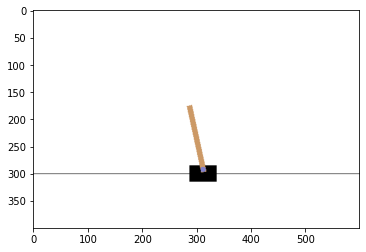

In [17]:
prev_screen = env.render(mode='rgb_array')
plt.imshow(prev_screen)

policy_dummy = lambda *obs: 1

for _ in range(2):
    obs = env.reset()
    for _ in range(80):
        actions = policy_dummy(*obs)
        obs, reward, done, info = env.step(actions) 

        screen = env.render(mode='rgb_array')

        plt.imshow(screen)
        ipythondisplay.clear_output(wait=True)
        ipythondisplay.display(plt.gcf())

        if done:
            break
        
ipythondisplay.clear_output(wait=True)
env.close()

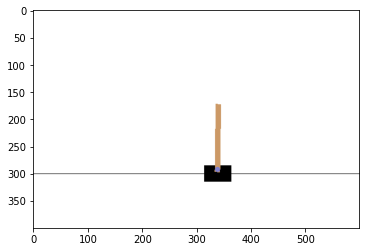

In [18]:
prev_screen = env.render(mode='rgb_array')
plt.imshow(prev_screen)


for _ in range(1):
    obs = env.reset()
    for _ in range(80):
        encoded = obs
        encoded_reshaped = encoded.reshape([1, encoded.shape[0]])
        predicted = policy.predict(encoded_reshaped).flatten()
        actions = np.argmax(predicted)
        obs, reward, done, info = env.step(actions) 

        screen = env.render(mode='rgb_array')

        plt.imshow(screen)
        ipythondisplay.clear_output(wait=True)
        ipythondisplay.display(plt.gcf())

        if done:
            break
        
ipythondisplay.clear_output(wait=True)
env.close()

In [19]:
policy.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 24)                120       
                                                                 
 dense_1 (Dense)             (None, 12)                300       
                                                                 
 dense_2 (Dense)             (None, 2)                 26        
                                                                 
Total params: 446
Trainable params: 446
Non-trainable params: 0
_________________________________________________________________
